In [1]:
import sys
!{sys.executable} -m pip install matplotlib

In [2]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [3]:
def pam_gray(b):
    if len(b)>1:
        return (1-2*b[0])*(2**len(b[1:]) - pam_gray(b[1:]))
    return 1-2*b[0]

def qam(num_bits_per_symbol, normalize=True):
    try:
        assert num_bits_per_symbol % 2 == 0 # is even
        assert num_bits_per_symbol >0 # is larger than zero
    except AssertionError as error:
        raise ValueError("num_bits_per_symbol must be a multiple of 2") \
        from error
    assert isinstance(normalize, bool), "normalize must be boolean"

    # Build constellation by iterating through all points
    c = np.zeros([2**num_bits_per_symbol], dtype=np.complex64)
    for i in range(0, 2**num_bits_per_symbol):
        b = np.array(list(np.binary_repr(i,num_bits_per_symbol)),
                     dtype=np.int16)
        c[i] = pam_gray(b[0::2]) + 1j*pam_gray(b[1::2]) # PAM in each dimension

    if normalize: # Normalize to unit energy
        n = int(num_bits_per_symbol/2)
        qam_var = 1/(2**(n-2))*np.sum(np.linspace(1,2**n-1, 2**(n-1))**2)
        c /= np.sqrt(qam_var)
    return c

def CreateConstellation(constellation_type, num_bits_per_symbol,normalize=True):
    num_bits_per_symbol = int(num_bits_per_symbol)
    if constellation_type=="qam":
        assert num_bits_per_symbol%2 == 0 and num_bits_per_symbol>0,\
            "num_bits_per_symbol must be a multiple of 2"
        num_bits_per_symbol = int(num_bits_per_symbol)

        points = qam(num_bits_per_symbol, normalize=normalize)
    return points

In [4]:
def show(points, num_bits_per_symbol, labels=True, figsize=(7,7)):
    """Generate a scatter-plot of the constellation.

    Input
    -----
    labels : bool
        If `True`, the bit labels will be drawn next to each constellation
        point. Defaults to `True`.

    figsize : Two-element Tuple, float
        Width and height in inches. Defaults to `(7,7)`.

    Output
    ------
    : matplotlib.figure.Figure
        A handle to a matplot figure object.
    """
    maxval = np.max(np.abs(points))*1.05
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    plt.xlim(-maxval, maxval)
    plt.ylim(-maxval, maxval)
    plt.scatter(np.real(points), np.imag(points))
    ax.set_aspect("equal", adjustable="box")
    plt.xlabel("Real Part")
    plt.ylabel("Imaginary Part")
    plt.grid(True, which="both", axis="both")
    plt.title("Constellation Plot")
    if labels is True:
        for j, p in enumerate(points):
            plt.annotate(
                np.binary_repr(j, num_bits_per_symbol),
                (np.real(p), np.imag(p))
            )
    return fig

In [5]:
NUM_BITS_PER_SYMBOL = 4 # QPSK: 2, QAM16
points = CreateConstellation("qam", NUM_BITS_PER_SYMBOL)
points.shape

(16,)

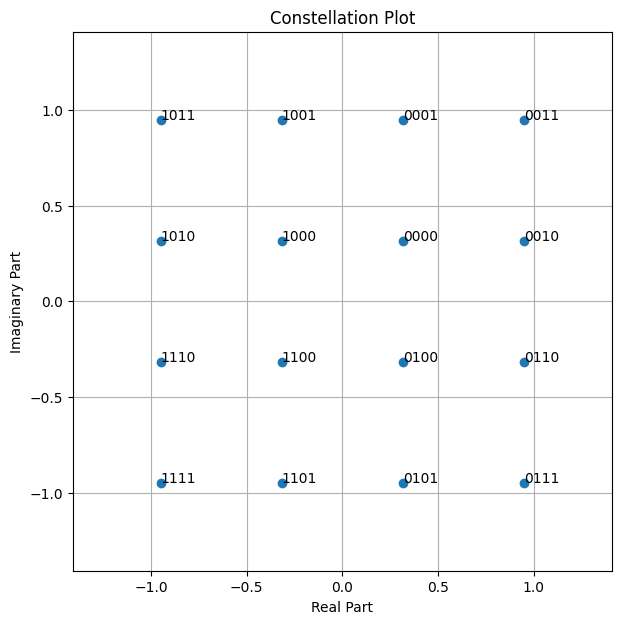

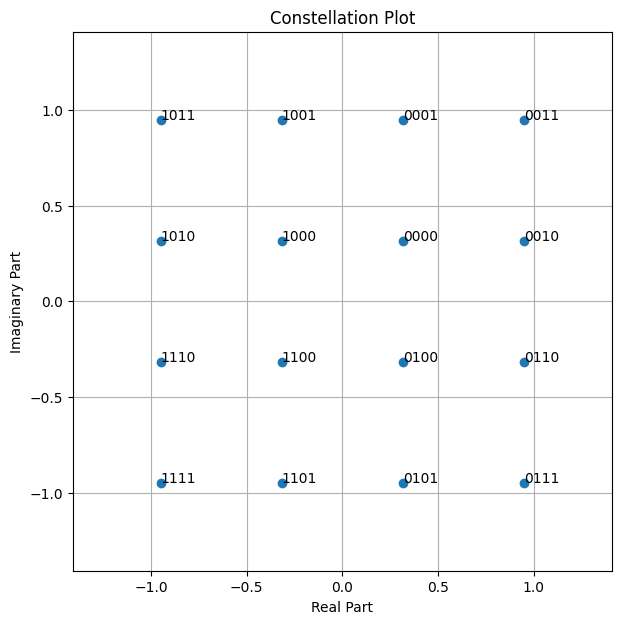

In [6]:
show(points, NUM_BITS_PER_SYMBOL)

In [7]:
def BinarySource(shape):
    return np.random.randint(2, size=shape).astype(np.float32)

In [8]:
def complex_normal(shape, var=1.0):
    stddev = np.sqrt(var/2)
    xr = np.random.normal(loc=0.0, scale=stddev, size=shape)
    xi = np.random.normal(loc=0.0, scale=stddev, size=shape)
    x = xr + 1j*xi
    return x

In [9]:
class Mapper:
    def __init__(self,
                 constellation_type=None,
                 num_bits_per_symbol=None,
                 constellation=None,
                 return_indices=False,
                 #dtype=tf.complex64,
                 #**kwargs
                ):
          self.num_bits_per_symbol = num_bits_per_symbol
          self.binary_base = 2**np.arange(num_bits_per_symbol-1, -1, -1, dtype=int) #array([2, 1], dtype=int32)
          self.points = CreateConstellation(constellation_type, num_bits_per_symbol) #(4,)
    
    def create_symbol(self, inputs):
        #inputs: (64, 1024) #batch_size, bits len
        new_shape = [-1] + [int(inputs.shape[-1] / self.num_bits_per_symbol), self.num_bits_per_symbol] #[-1, 512, 2]
        reinputs_reshaped = np.reshape(inputs, new_shape) #(64, 512, 2)
        # Convert the last dimension to an integer
        int_rep = reinputs_reshaped * self.binary_base #(64, 512, 2)
        int_rep = np.sum(int_rep, axis=-1) #(64, 512)
        int_rep = int_rep.astype(np.int32)
        #print(int_rep.shape)
        # Map integers to constellation symbols
        #x = tf.gather(self.points, int_rep, axis=0)
        symbs_list = [self.points[val_int] for val_int in int_rep]
        symbols=np.array(symbs_list) #(64, 512) complex64
        #print(symbols.dtype)
        return symbols

In [10]:
def ebnodb2no(ebno_db, num_bits_per_symbol, coderate):
    r"""Compute the noise variance `No` for a given `Eb/No` in dB.
    Input
    -----
    ebno_db : float
        The `Eb/No` value in dB.

    num_bits_per_symbol : int
        The number of bits per symbol.

    coderate : float
        The coderate used.

    Output
    ------
    : float
        The value of :math:`N_o` in linear scale.
    """
    #ebno = tf.math.pow(tf.cast(10., dtype), ebno_db/10.)
    ebno = np.power(10, ebno_db/10.0)
    energy_per_symbol = 1
    tmp= (ebno * coderate * float(num_bits_per_symbol)) / float(energy_per_symbol)
    n0 = 1/tmp
    return n0

In [11]:
# custom dataset
class ComplexDataset(Dataset):
    def __init__(self, num_bits_per_symbol, Frame_SIZE=64, Blocklength = 1024, DB_MIN=-10, DB_MAX=20, totaldbs=2000, constellation_type="qam", data_type=np.complex64):
        self.points = CreateConstellation(constellation_type, num_bits_per_symbol)
        print(self.points.shape) #(4,) complex64
        self.shape = ([Frame_SIZE, Blocklength])# Blocklength [64, 1024]
        self.constellation_type = constellation_type
        self.num_bits_per_symbol = num_bits_per_symbol
        self.data_type = data_type
        self.mapper=Mapper(constellation_type=constellation_type, num_bits_per_symbol=num_bits_per_symbol)

        ebno_dbs=np.linspace(DB_MIN, DB_MAX, totaldbs)
        np.random.shuffle(ebno_dbs)
        self.ebno_dbs = ebno_dbs
    
    def __getitem__(self, index):
        ebno_db = self.ebno_dbs[index]

        bits = BinarySource(self.shape)
        #print("Shape of bits: ", bits.shape) #(64, 1024)

        x=self.mapper.create_symbol(bits) #(64, 512) complex64

        n0=ebnodb2no(ebno_db=ebno_db, num_bits_per_symbol=self.num_bits_per_symbol, coderate=1.0) #scalar 0.05
        noise=complex_normal(x.shape, 1.0) #(64, 512) complex128
        #print(noise.dtype)
        noise = noise.astype(self.data_type)
        noise *= np.sqrt(n0) 
        y=x+noise #(64, 512)
        signal_complex = torch.from_numpy(y)

        batch={}
        batch['samples']=signal_complex #(64, 512)
        batch['labels']=bits #(64, 1024)
        return batch
    
    def __len__(self):
        return len(self.ebno_dbs)

In [12]:
NUM_BITS_PER_SYMBOL = 4
BATCH_SIZE = 32
Frame_SIZE = 64
Blocklength = 1024
DB_MIN = -20
DB_MAX = 20
dataset = ComplexDataset(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, Frame_SIZE=Frame_SIZE, Blocklength=Blocklength, DB_MIN=DB_MIN, DB_MAX=DB_MAX, totaldbs=BATCH_SIZE*100)

(16,)


In [13]:
onesample = dataset[0]

In [14]:
onesample.keys()

dict_keys(['samples', 'labels'])

In [15]:
onesample['samples'].shape

torch.Size([64, 256])

In [16]:
onesample['labels'].shape

(64, 1024)

In [17]:
# train, validation and test split
train_size = int(0.8 * len(dataset)) 
val_size = len(dataset) - train_size
train_set, val_set= torch.utils.data.random_split(dataset, [train_size, val_size])

# dataloaders
train_loader = DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(dataset=val_set, batch_size=1, shuffle=True, pin_memory=True)


In [18]:
onebatch = next(iter(val_loader))

In [19]:
onebatch['samples'].shape

torch.Size([1, 64, 256])

In [20]:
onebatch = next(iter(train_loader))

In [21]:
onebatch['samples'].shape

torch.Size([32, 64, 256])

In [22]:
gpuid=0
if torch.cuda.is_available():
    device = torch.device('cuda:'+str(gpuid))  # CUDA GPU 0
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print("Using device:", device)

Using device: mps


In [23]:
class Simplemodel(nn.Module):

    def __init__(self, num_bits_per_symbol, H=64, W=512):
        super(Simplemodel, self).__init__()
        scale = 8
        self.linear1=nn.Linear(in_features=2, out_features=scale*num_bits_per_symbol)
        self.linear2=nn.Linear(in_features=scale*num_bits_per_symbol, out_features=num_bits_per_symbol)
        self.activation = nn.ReLU()
    
    def forward(self, inputs):
        y = inputs #[64, 64, 512]
   
        # Stack the tensors along a new dimension (axis 0)
        z = torch.stack([y.real, y.imag], dim=0) #[2, 64, 64, 512]
        z = z.permute(1, 2, 3, 0) #[64, 64, 512, 2]
        z = self.linear1(z)
        z = self.activation(z)
        z = self.linear2(z)
        z = nn.Sigmoid()(z) #[64, 64, 512, num_bits_per_symbol]
        z = z.flatten(-2, -1) #combine last two dimension => [64, 64, 512*num_bits_per_symbol]
        return z

In [24]:
model = Simplemodel(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength)

In [25]:
output = model(onebatch['samples']) #[32, 64, 512] =>[32, 64, 1024]

In [26]:
output.shape

torch.Size([32, 64, 1024])

In [27]:
output.dtype

torch.float32

In [28]:
# Setup loss and optimizer pip install ipywidgets
loss_fn = nn.BCELoss() #nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [29]:
test=torch.tensor([0,0,0,1,1,1], dtype=torch.float)

In [30]:
loss_fn(test,test)

tensor(0.)

In [31]:
onebatch['labels'].dtype

torch.float32

In [32]:
loss_fn(output,onebatch['labels'])

tensor(0.7107, grad_fn=<BinaryCrossEntropyBackward0>)

In [33]:
import os
trainoutput=os.path.join('output','exp0212')
os.makedirs(trainoutput, exist_ok=True)
print("Trainoutput folder:", trainoutput)

Trainoutput folder: output/exp0212


In [34]:
train_losses = []
val_losses = []
val_BERs = []

In [35]:
model=model.to(device)

In [36]:
from tqdm.auto import tqdm
# Training loop
start_epoch = 0
num_epochs =20
for epoch in range(start_epoch, num_epochs):
    total_loss = 0.0
    model.train()  # Set the model to training mode

    for index, data_batch in enumerate(tqdm(train_loader)):
        batch = {k: v.to(device) for k, v in data_batch.items()}
        samples = batch['samples']
        labels = batch['labels']
        outputs = model(samples)  # forward pass 
        loss = loss_fn(outputs, labels) 
        loss.backward()  # backward pass
        optimizer.step()  # update the weights
        total_loss += loss.item()  # accumulate the loss
        optimizer.zero_grad()  # Zero the gradients

    # Print average loss for the epoch
    average_loss = total_loss / len(train_loader)

    # Validation
    model.eval()  # Set the model to evaluation mode
    BER_batch=[]
    with torch.no_grad():
        for index, data_batch in enumerate(tqdm(val_loader)):
            batch = {k: v.to(device) for k, v in data_batch.items()}
            samples = batch['samples']
            labels = batch['labels']
            val_outputs = model(samples)
            val_loss = loss_fn(val_outputs, labels)

            # Convert probabilities to binary predictions (0 or 1)
            binary_predictions = torch.round(val_outputs)

            # Calculate Bit Error Rate (BER)
            error_count = torch.sum(binary_predictions != labels).float()  # Count of unequal bits
            error_rate = error_count / len(labels.flatten())  # Error rate calculation
            BER_batch.append(error_rate.item())
            
    # Save performance details
    train_losses.append(average_loss)
    val_losses.append(val_loss.item())
    BER_batch_mean=np.mean(BER_batch)
    val_BERs.append(BER_batch_mean)#(BER.item())

    # Print or log validation loss after each epoch
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}, Val Loss: {val_loss:.4f}, Val BER: {BER_batch_mean:.4f}")


/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|████████████████████████████████████████| 640/640 [00:03<00:00, 168.80it/s]


Epoch [1/20], Loss: 0.6525, Val Loss: 0.5992, Val BER: 0.2936


100%|████████████████████████████████████████| 640/640 [00:02<00:00, 223.03it/s]


Epoch [2/20], Loss: 0.6125, Val Loss: 0.5859, Val BER: 0.2535


100%|████████████████████████████████████████| 640/640 [00:02<00:00, 229.39it/s]


Epoch [3/20], Loss: 0.6011, Val Loss: 0.5269, Val BER: 0.2256


100%|████████████████████████████████████████| 640/640 [00:02<00:00, 232.86it/s]


Epoch [4/20], Loss: 0.5951, Val Loss: 0.6226, Val BER: 0.2228


100%|████████████████████████████████████████| 640/640 [00:02<00:00, 225.88it/s]


Epoch [5/20], Loss: 0.5909, Val Loss: 0.7212, Val BER: 0.2294


100%|████████████████████████████████████████| 640/640 [00:02<00:00, 220.28it/s]


Epoch [6/20], Loss: 0.5874, Val Loss: 0.5851, Val BER: 0.2226


100%|████████████████████████████████████████| 640/640 [00:02<00:00, 224.01it/s]


Epoch [7/20], Loss: 0.5842, Val Loss: 0.5211, Val BER: 0.2275


100%|████████████████████████████████████████| 640/640 [00:02<00:00, 232.11it/s]


Epoch [8/20], Loss: 0.5811, Val Loss: 0.4847, Val BER: 0.2274


100%|████████████████████████████████████████| 640/640 [00:02<00:00, 223.89it/s]


Epoch [9/20], Loss: 0.5781, Val Loss: 0.9545, Val BER: 0.2217


100%|████████████████████████████████████████| 640/640 [00:03<00:00, 206.34it/s]


Epoch [10/20], Loss: 0.5750, Val Loss: 0.4737, Val BER: 0.2204


100%|████████████████████████████████████████| 640/640 [00:02<00:00, 214.84it/s]


Epoch [11/20], Loss: 0.5720, Val Loss: 0.4704, Val BER: 0.2189


100%|████████████████████████████████████████| 640/640 [00:03<00:00, 188.86it/s]


Epoch [12/20], Loss: 0.5690, Val Loss: 0.8629, Val BER: 0.2155


100%|████████████████████████████████████████| 640/640 [00:03<00:00, 209.62it/s]


Epoch [13/20], Loss: 0.5658, Val Loss: 0.6226, Val BER: 0.2128


100%|████████████████████████████████████████| 640/640 [00:03<00:00, 208.46it/s]


Epoch [14/20], Loss: 0.5625, Val Loss: 0.4552, Val BER: 0.2124


100%|████████████████████████████████████████| 640/640 [00:03<00:00, 207.49it/s]


Epoch [15/20], Loss: 0.5593, Val Loss: 0.4503, Val BER: 0.2071


100%|████████████████████████████████████████| 640/640 [00:03<00:00, 207.26it/s]


Epoch [16/20], Loss: 0.5559, Val Loss: 0.5561, Val BER: 0.2070


100%|████████████████████████████████████████| 640/640 [00:02<00:00, 213.86it/s]


Epoch [17/20], Loss: 0.5525, Val Loss: 0.4400, Val BER: 0.2025


100%|████████████████████████████████████████| 640/640 [00:03<00:00, 209.96it/s]


Epoch [18/20], Loss: 0.5490, Val Loss: 0.4920, Val BER: 0.2037


100%|████████████████████████████████████████| 640/640 [00:03<00:00, 205.58it/s]


Epoch [19/20], Loss: 0.5455, Val Loss: 0.4504, Val BER: 0.2024


100%|████████████████████████████████████████| 640/640 [00:02<00:00, 213.35it/s]

Epoch [20/20], Loss: 0.5420, Val Loss: 0.6340, Val BER: 0.2006


In [37]:
# Save the final trained model
checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
}
modelsave_path = os.path.join(trainoutput, 'simple_model.pth')
torch.save(checkpoint, modelsave_path)

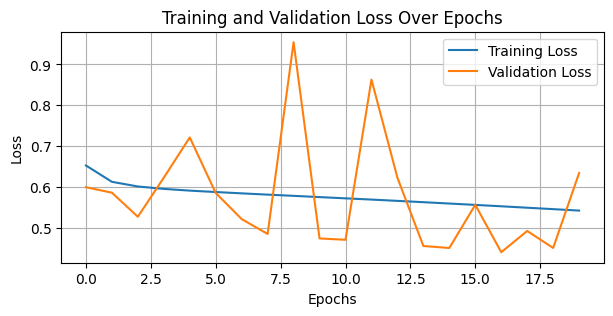

In [38]:
# Plot Training Loss and Validation Loss
plt.figure(figsize=(7, 3))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.grid(True)

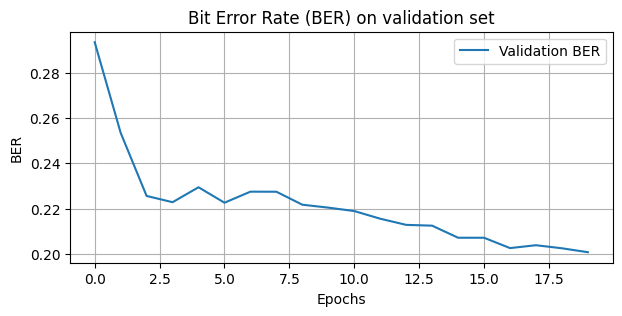

In [39]:
# Plot Validation BER
plt.figure(figsize=(7, 3))
plt.plot(val_BERs, label='Validation BER')
plt.xlabel('Epochs')
plt.ylabel('BER')
plt.legend()
plt.title('Bit Error Rate (BER) on validation set')
plt.grid(True)

In [40]:
class EnhancedSimpleModel2(nn.Module):

    def __init__(self, num_bits_per_symbol, H=64, W=512):
        super(EnhancedSimpleModel2, self).__init__()
        scale = 16
        self.linear1 = nn.Linear(in_features=2, out_features=scale * num_bits_per_symbol)
        self.linear2 = nn.Linear(in_features=scale * num_bits_per_symbol, out_features=scale * num_bits_per_symbol * 2)
        self.linear3 = nn.Linear(in_features=scale * num_bits_per_symbol * 2, out_features=scale * num_bits_per_symbol * 2)
        self.linear4 = nn.Linear(in_features=scale * num_bits_per_symbol * 2, out_features=num_bits_per_symbol)
        self.activation = nn.LeakyReLU()

    def forward(self, inputs):
        y = inputs
        z = torch.stack([y.real, y.imag], dim=0)
        z = z.permute(1, 2, 3, 0)
        z = self.linear1(z)
        z = self.activation(z)
        z = self.linear2(z)
        z = self.activation(z)
        z = self.linear3(z)
        z = self.activation(z)
        z = self.linear4(z)
        z = nn.Sigmoid()(z)
        z = z.flatten(-2, -1)
        return z

In [41]:
model = EnhancedSimpleModel2(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength)

In [42]:
output = model(onebatch['samples']) #[32, 64, 512] =>[32, 64, 1024]

In [43]:
# Setup loss and optimizer pip install ipywidgets
loss_fn = nn.BCELoss() #nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)


In [44]:
train_losses = []
val_losses = []
val_BERs = []

In [45]:
model=model.to(device)

In [46]:
from tqdm.auto import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Initialize the ReduceLROnPlateau scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.01)

start_epoch = 0
num_epochs = 15
for epoch in range(start_epoch, num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0.0

    for data_batch in tqdm(train_loader):
        batch = {k: v.to(device) for k, v in data_batch.items()}
        samples = batch['samples']
        labels = batch['labels']
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(samples)  # forward pass
        loss = loss_fn(outputs, labels)
        loss.backward()  # backward pass
        optimizer.step()  # update the weights
        total_loss += loss.item()  # accumulate the loss

    # Print average loss for the epoch
    average_loss = total_loss / len(train_loader)

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    total_val_loss = 0.0
    BER_batch = []
    with torch.no_grad():
        for data_batch in tqdm(val_loader):
            batch = {k: v.to(device) for k, v in data_batch.items()}
            samples = batch['samples']
            labels = batch['labels']
            val_outputs = model(samples)
            val_loss = loss_fn(val_outputs, labels)
            total_val_loss += val_loss.item()

            binary_predictions = torch.round(val_outputs)
            error_count = torch.sum(binary_predictions != labels).float()
            error_rate = error_count / len(labels.flatten())
            BER_batch.append(error_rate.item())

    # Calculate average validation loss
    average_val_loss = total_val_loss / len(val_loader)
    BER_batch_mean = np.mean(BER_batch)
         
    # Save performance details
    train_losses.append(average_loss)
    val_losses.append(val_loss.item())
    BER_batch_mean=np.mean(BER_batch)
    val_BERs.append(BER_batch_mean)#(BER.item())
    # Step the scheduler with the average validation loss
    scheduler.step(average_val_loss)

    # Logging
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}, Val Loss: {average_val_loss:.4f}, Val BER: {BER_batch_mean:.4f}")


100%|████████████████████████████████████████| 640/640 [00:05<00:00, 109.03it/s]


Epoch [1/15], Loss: 0.7386, Val Loss: 0.4306, Val BER: 0.1935


100%|████████████████████████████████████████| 640/640 [00:05<00:00, 121.98it/s]


Epoch [2/15], Loss: 0.4150, Val Loss: 0.4264, Val BER: 0.1932


100%|████████████████████████████████████████| 640/640 [00:05<00:00, 118.35it/s]


Epoch [3/15], Loss: 0.4113, Val Loss: 0.4253, Val BER: 0.1928


100%|████████████████████████████████████████| 640/640 [00:05<00:00, 108.46it/s]


Epoch [4/15], Loss: 0.4122, Val Loss: 0.4202, Val BER: 0.1918


100%|████████████████████████████████████████| 640/640 [00:06<00:00, 101.70it/s]


Epoch [5/15], Loss: 0.4106, Val Loss: 0.4277, Val BER: 0.1915


100%|████████████████████████████████████████| 640/640 [00:05<00:00, 118.77it/s]


Epoch [6/15], Loss: 0.4082, Val Loss: 0.4205, Val BER: 0.1912


100%|████████████████████████████████████████| 640/640 [00:05<00:00, 114.07it/s]


Epoch [7/15], Loss: 0.4082, Val Loss: 0.4182, Val BER: 0.1913


100%|████████████████████████████████████████| 640/640 [00:05<00:00, 113.09it/s]


Epoch [8/15], Loss: 0.4080, Val Loss: 0.4186, Val BER: 0.1917


100%|████████████████████████████████████████| 640/640 [00:05<00:00, 113.47it/s]


Epoch [9/15], Loss: 0.4080, Val Loss: 0.4224, Val BER: 0.1919


100%|████████████████████████████████████████| 640/640 [00:05<00:00, 117.69it/s]


Epoch [10/15], Loss: 0.4086, Val Loss: 0.4411, Val BER: 0.1924


100%|████████████████████████████████████████| 640/640 [00:05<00:00, 119.74it/s]


Epoch [11/15], Loss: 0.4067, Val Loss: 0.4271, Val BER: 0.1920


100%|████████████████████████████████████████| 640/640 [00:05<00:00, 114.04it/s]


Epoch [12/15], Loss: 0.4084, Val Loss: 0.4191, Val BER: 0.1921


100%|████████████████████████████████████████| 640/640 [00:05<00:00, 109.38it/s]


Epoch [13/15], Loss: 0.4060, Val Loss: 0.4152, Val BER: 0.1909


100%|████████████████████████████████████████| 640/640 [00:05<00:00, 115.42it/s]


Epoch [14/15], Loss: 0.4049, Val Loss: 0.4197, Val BER: 0.1920


100%|████████████████████████████████████████| 640/640 [00:05<00:00, 107.56it/s]

Epoch [15/15], Loss: 0.4077, Val Loss: 0.4168, Val BER: 0.1918


In [47]:
# Save the final trained model
checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
}
modelsave_path = os.path.join(trainoutput, 'simple_model.pth')
torch.save(checkpoint, modelsave_path)

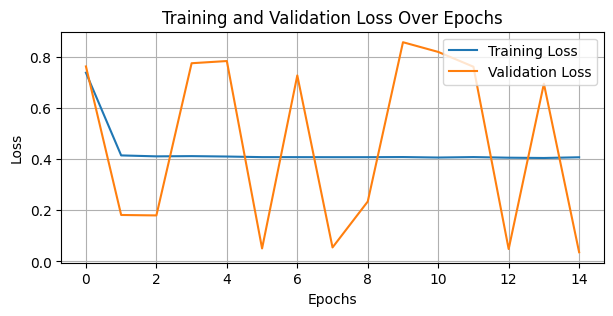

In [48]:
# Plot Training Loss and Validation Loss
plt.figure(figsize=(7, 3))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.grid(True)

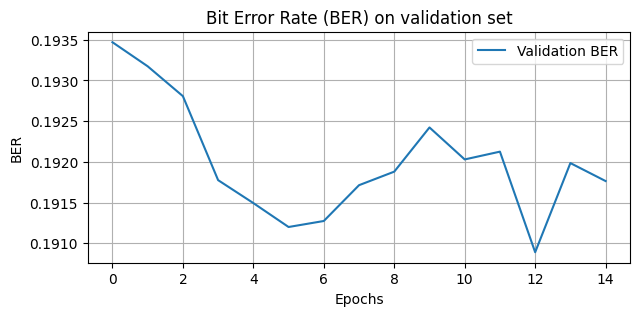

In [49]:
# Plot Validation BER
plt.figure(figsize=(7, 3))
plt.plot(val_BERs, label='Validation BER')
plt.xlabel('Epochs')
plt.ylabel('BER')
plt.legend()
plt.title('Bit Error Rate (BER) on validation set')
plt.grid(True)

In [50]:
class EnhancedSimpleModel3(nn.Module):

    def __init__(self, num_bits_per_symbol, H=64, W=512):
        super(EnhancedSimpleModel3, self).__init__()
        scale = 8
        self.linear1 = nn.Linear(in_features=2, out_features=scale * num_bits_per_symbol)
        self.linear2 = nn.Linear(in_features=scale * num_bits_per_symbol, out_features=scale * num_bits_per_symbol * 2)
        self.linear3 = nn.Linear(in_features=scale * num_bits_per_symbol * 2, out_features=scale * num_bits_per_symbol * 2)
        self.linear4 = nn.Linear(in_features=scale * num_bits_per_symbol * 2, out_features=scale * num_bits_per_symbol)
        self.linear5 = nn.Linear(in_features=scale * num_bits_per_symbol, out_features=num_bits_per_symbol)
        self.activation = nn.ReLU()

    def forward(self, inputs):
        y = inputs
        z = torch.stack([y.real, y.imag], dim=0)
        z = z.permute(1, 2, 3, 0)
        z = self.linear1(z)
        z = self.activation(z)
        z = self.linear2(z)
        z = self.activation(z)
        z = self.linear3(z)
        z = self.activation(z)
        z = self.linear4(z)
        z = self.activation(z)
        z = self.linear5(z)
        z = nn.Sigmoid()(z)
        z = z.flatten(-2, -1)
        return z

In [51]:
model = EnhancedSimpleModel3(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength)

In [52]:
output = model(onebatch['samples']) #[32, 64, 512] =>[32, 64, 1024]

In [53]:
# Setup loss and optimizer pip install ipywidgets
loss_fn = nn.BCELoss() #nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)


In [54]:
train_losses = []
val_losses = []
val_BERs = []

In [55]:
model=model.to(device)

In [56]:
from tqdm.auto import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Initialize the ReduceLROnPlateau scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.01)

start_epoch = 0
num_epochs = 15
for epoch in range(start_epoch, num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0.0

    for data_batch in tqdm(train_loader):
        batch = {k: v.to(device) for k, v in data_batch.items()}
        samples = batch['samples']
        labels = batch['labels']
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(samples)  # forward pass
        loss = loss_fn(outputs, labels)
        loss.backward()  # backward pass
        optimizer.step()  # update the weights
        total_loss += loss.item()  # accumulate the loss

    # Print average loss for the epoch
    average_loss = total_loss / len(train_loader)

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    total_val_loss = 0.0
    BER_batch = []
    with torch.no_grad():
        for data_batch in tqdm(val_loader):
            batch = {k: v.to(device) for k, v in data_batch.items()}
            samples = batch['samples']
            labels = batch['labels']
            val_outputs = model(samples)
            val_loss = loss_fn(val_outputs, labels)
            total_val_loss += val_loss.item()

            binary_predictions = torch.round(val_outputs)
            error_count = torch.sum(binary_predictions != labels).float()
            error_rate = error_count / len(labels.flatten())
            BER_batch.append(error_rate.item())

    
    average_val_loss = total_val_loss / len(val_loader)
    BER_batch_mean = np.mean(BER_batch)
    if epoch%5==0:
        scheduler.step(average_val_loss)
    train_losses.append(average_loss)
    val_losses.append(val_loss.item())
    BER_batch_mean=np.mean(BER_batch)
    val_BERs.append(BER_batch_mean)#(BER.item())

    # Logging
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}, Val Loss: {average_val_loss:.4f}, Val BER: {BER_batch_mean:.4f}")


100%|████████████████████████████████████████| 640/640 [00:04<00:00, 138.58it/s]


Epoch [1/15], Loss: 0.6408, Val Loss: 0.5192, Val BER: 0.2546


100%|████████████████████████████████████████| 640/640 [00:04<00:00, 143.07it/s]


Epoch [2/15], Loss: 0.4968, Val Loss: 0.4980, Val BER: 0.2296


100%|████████████████████████████████████████| 640/640 [00:04<00:00, 141.51it/s]


Epoch [3/15], Loss: 0.4621, Val Loss: 0.4518, Val BER: 0.1983


100%|████████████████████████████████████████| 640/640 [00:04<00:00, 134.16it/s]


Epoch [4/15], Loss: 0.4295, Val Loss: 0.4336, Val BER: 0.1953


100%|████████████████████████████████████████| 640/640 [00:04<00:00, 146.34it/s]


Epoch [5/15], Loss: 0.4239, Val Loss: 0.4364, Val BER: 0.1968


100%|████████████████████████████████████████| 640/640 [00:04<00:00, 145.45it/s]


Epoch [6/15], Loss: 0.4228, Val Loss: 0.4299, Val BER: 0.1945


100%|████████████████████████████████████████| 640/640 [00:04<00:00, 144.41it/s]


Epoch [7/15], Loss: 0.4202, Val Loss: 0.4310, Val BER: 0.1956


100%|████████████████████████████████████████| 640/640 [00:05<00:00, 126.88it/s]


Epoch [8/15], Loss: 0.4203, Val Loss: 0.4313, Val BER: 0.1935


100%|████████████████████████████████████████| 640/640 [00:04<00:00, 135.83it/s]


Epoch [9/15], Loss: 0.4182, Val Loss: 0.4343, Val BER: 0.1953


100%|████████████████████████████████████████| 640/640 [00:05<00:00, 125.53it/s]


Epoch [10/15], Loss: 0.4204, Val Loss: 0.4354, Val BER: 0.1980


100%|████████████████████████████████████████| 640/640 [00:04<00:00, 140.14it/s]


Epoch [11/15], Loss: 0.4178, Val Loss: 0.4321, Val BER: 0.1935


100%|████████████████████████████████████████| 640/640 [00:05<00:00, 120.97it/s]


Epoch [12/15], Loss: 0.4210, Val Loss: 0.4306, Val BER: 0.1963


100%|████████████████████████████████████████| 640/640 [00:04<00:00, 128.62it/s]


Epoch [13/15], Loss: 0.4205, Val Loss: 0.4307, Val BER: 0.1932


100%|████████████████████████████████████████| 640/640 [00:04<00:00, 129.19it/s]


Epoch [14/15], Loss: 0.4185, Val Loss: 0.4289, Val BER: 0.1939


100%|████████████████████████████████████████| 640/640 [00:04<00:00, 129.07it/s]

Epoch [15/15], Loss: 0.4188, Val Loss: 0.4359, Val BER: 0.1956


In [57]:
# Save the final trained model
checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
}
modelsave_path = os.path.join(trainoutput, 'simple_model.pth')
torch.save(checkpoint, modelsave_path)

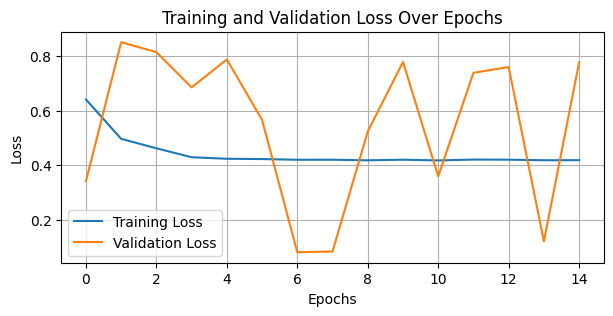

In [58]:
# Plot Training Loss and Validation Loss
plt.figure(figsize=(7, 3))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.grid(True)

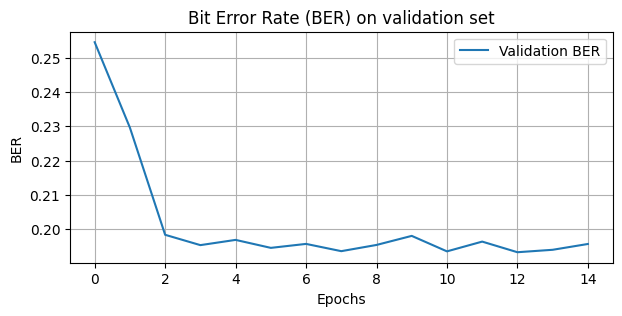

In [59]:
# Plot Validation BER
plt.figure(figsize=(7, 3))
plt.plot(val_BERs, label='Validation BER')
plt.xlabel('Epochs')
plt.ylabel('BER')
plt.legend()
plt.title('Bit Error Rate (BER) on validation set')
plt.grid(True)

In [60]:
class EnhancedSimpleModel4(nn.Module):

    def __init__(self, num_bits_per_symbol, H=64, W=512):
        super(EnhancedSimpleModel4, self).__init__()
        scale = 8
        self.linear1 = nn.Linear(in_features=2, out_features=scale * num_bits_per_symbol)
        self.linear2 = nn.Linear(in_features=scale * num_bits_per_symbol, out_features=scale * num_bits_per_symbol * 2)
        self.linear3 = nn.Linear(in_features=scale * num_bits_per_symbol * 2, out_features=scale * num_bits_per_symbol * 2)
        self.linear4 = nn.Linear(in_features=scale * num_bits_per_symbol * 2, out_features=scale * num_bits_per_symbol)
        self.linear5 = nn.Linear(in_features=scale * num_bits_per_symbol, out_features=num_bits_per_symbol)
        self.activation = nn.PReLU()


    def forward(self, inputs):
        y = inputs
        z = torch.stack([y.real, y.imag], dim=0)
        z = z.permute(1, 2, 3, 0)
        z = self.linear1(z)
        z = self.activation(z)
        z = self.linear2(z)
        z = self.activation(z)
        z = self.linear3(z)
        z = self.activation(z)
        z = self.linear4(z)
        z = self.activation(z)
        z = self.linear5(z)
        z = nn.Sigmoid()(z)
        z = z.flatten(-2, -1)
        return z

In [61]:
model = EnhancedSimpleModel4(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength)
output = model(onebatch['samples']) #[32, 64, 512] =>[32, 64, 1024]
# Setup loss and optimizer pip install ipywidgets
loss_fn = nn.BCELoss() #nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)


In [62]:
train_losses = []
val_losses = []
val_BERs = []

In [63]:
model=model.to(device)

In [64]:
from tqdm.auto import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Initialize the ReduceLROnPlateau scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.01)

start_epoch = 0
num_epochs = 15
for epoch in range(start_epoch, num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0.0

    for data_batch in tqdm(train_loader):
        batch = {k: v.to(device) for k, v in data_batch.items()}
        samples = batch['samples']
        labels = batch['labels']
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(samples)  # forward pass
        loss = loss_fn(outputs, labels)
        loss.backward()  # backward pass
        optimizer.step()  # update the weights
        total_loss += loss.item()  # accumulate the loss

    # Print average loss for the epoch
    average_loss = total_loss / len(train_loader)

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    total_val_loss = 0.0
    BER_batch = []
    with torch.no_grad():
        for data_batch in tqdm(val_loader):
            batch = {k: v.to(device) for k, v in data_batch.items()}
            samples = batch['samples']
            labels = batch['labels']
            val_outputs = model(samples)
            val_loss = loss_fn(val_outputs, labels)
            total_val_loss += val_loss.item()

            binary_predictions = torch.round(val_outputs)
            error_count = torch.sum(binary_predictions != labels).float()
            error_rate = error_count / len(labels.flatten())
            BER_batch.append(error_rate.item())

    
    average_val_loss = total_val_loss / len(val_loader)
    BER_batch_mean = np.mean(BER_batch)
    if epoch%5==0:
        scheduler.step(average_val_loss)
    train_losses.append(average_loss)
    val_losses.append(val_loss.item())
    BER_batch_mean=np.mean(BER_batch)
    val_BERs.append(BER_batch_mean)#(BER.item())

    # Logging
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}, Val Loss: {average_val_loss:.4f}, Val BER: {BER_batch_mean:.4f}")


100%|████████████████████████████████████████| 640/640 [00:05<00:00, 121.41it/s]


Epoch [1/15], Loss: 0.5939, Val Loss: 0.4549, Val BER: 0.2010


100%|████████████████████████████████████████| 640/640 [00:04<00:00, 129.01it/s]


Epoch [2/15], Loss: 0.4316, Val Loss: 0.4331, Val BER: 0.1952


100%|████████████████████████████████████████| 640/640 [00:05<00:00, 123.95it/s]


Epoch [3/15], Loss: 0.4228, Val Loss: 0.4371, Val BER: 0.1942


100%|████████████████████████████████████████| 640/640 [00:05<00:00, 123.53it/s]


Epoch [4/15], Loss: 0.4175, Val Loss: 0.4266, Val BER: 0.1918


100%|████████████████████████████████████████| 640/640 [00:05<00:00, 115.04it/s]


Epoch [5/15], Loss: 0.4151, Val Loss: 0.4253, Val BER: 0.1933


100%|████████████████████████████████████████| 640/640 [00:05<00:00, 120.55it/s]


Epoch [6/15], Loss: 10.3061, Val Loss: 49.9916, Val BER: 0.4999


100%|████████████████████████████████████████| 640/640 [00:05<00:00, 118.43it/s]


Epoch [7/15], Loss: 49.9967, Val Loss: 49.9936, Val BER: 0.4999


100%|████████████████████████████████████████| 640/640 [00:04<00:00, 131.49it/s]


Epoch [8/15], Loss: 49.9978, Val Loss: 49.9984, Val BER: 0.5000


100%|████████████████████████████████████████| 640/640 [00:04<00:00, 135.87it/s]


Epoch [9/15], Loss: 49.9937, Val Loss: 49.9947, Val BER: 0.4999


100%|████████████████████████████████████████| 640/640 [00:04<00:00, 137.28it/s]


Epoch [10/15], Loss: 49.9980, Val Loss: 50.0000, Val BER: 0.5000


100%|████████████████████████████████████████| 640/640 [00:04<00:00, 134.60it/s]


Epoch [11/15], Loss: 50.0026, Val Loss: 50.0234, Val BER: 0.5002


100%|████████████████████████████████████████| 640/640 [00:04<00:00, 135.49it/s]


Epoch [12/15], Loss: 50.0001, Val Loss: 50.0054, Val BER: 0.5001


100%|████████████████████████████████████████| 640/640 [00:04<00:00, 133.36it/s]


Epoch [13/15], Loss: 50.0073, Val Loss: 49.9905, Val BER: 0.4999


100%|████████████████████████████████████████| 640/640 [00:04<00:00, 130.27it/s]


Epoch [14/15], Loss: 50.0030, Val Loss: 50.0138, Val BER: 0.5001


100%|████████████████████████████████████████| 640/640 [00:04<00:00, 138.07it/s]

Epoch [15/15], Loss: 49.9975, Val Loss: 49.9983, Val BER: 0.5000


In [65]:
# Save the final trained model
checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
}
modelsave_path = os.path.join(trainoutput, 'simple_model.pth')
torch.save(checkpoint, modelsave_path)

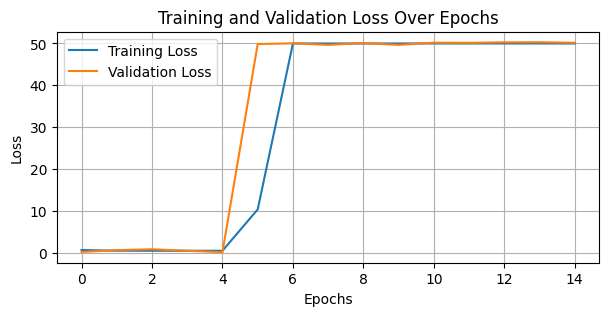

In [66]:
# Plot Training Loss and Validation Loss
plt.figure(figsize=(7, 3))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.grid(True)

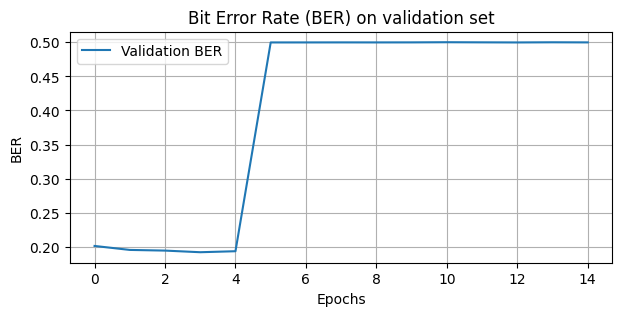

In [67]:
# Plot Validation BER
plt.figure(figsize=(7, 3))
plt.plot(val_BERs, label='Validation BER')
plt.xlabel('Epochs')
plt.ylabel('BER')
plt.legend()
plt.title('Bit Error Rate (BER) on validation set')
plt.grid(True)

Doesnt look like increasing the layers or changing activation function or increasing the epochs does anything. Increasing the neurons now.

In [68]:
class EnhancedSimpleModel5(nn.Module):

    def __init__(self, num_bits_per_symbol, H=64, W=512):
        super(EnhancedSimpleModel5, self).__init__()
        scale = 8
        self.linear1 = nn.Linear(in_features=2, out_features=scale * num_bits_per_symbol)
        self.linear2 = nn.Linear(in_features=scale * num_bits_per_symbol, out_features=scale * num_bits_per_symbol * 4)
        self.linear3 = nn.Linear(in_features=scale * num_bits_per_symbol * 4, out_features=scale * num_bits_per_symbol)
        self.linear4 = nn.Linear(in_features=scale * num_bits_per_symbol, out_features=num_bits_per_symbol)
        self.activation = nn.PReLU()


    def forward(self, inputs):
        y = inputs
        z = torch.stack([y.real, y.imag], dim=0)
        z = z.permute(1, 2, 3, 0)
        z = self.linear1(z)
        z = self.activation(z)
        z = self.linear2(z)
        z = self.activation(z)
        z = self.linear3(z)
        z = self.activation(z)
        
        z = self.linear4(z)
        z = nn.Sigmoid()(z)
        z = z.flatten(-2, -1)
        return z

In [69]:
model = EnhancedSimpleModel5(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength)
output = model(onebatch['samples']) #[32, 64, 512] =>[32, 64, 1024]
# Setup loss and optimizer pip install ipywidgets
loss_fn = nn.BCELoss() #nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)


In [70]:
train_losses = []
val_losses = []
val_BERs = []

In [71]:
model=model.to(device)

In [72]:
from tqdm.auto import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Initialize the ReduceLROnPlateau scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.01)

start_epoch = 0
num_epochs = 10
for epoch in range(start_epoch, num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0.0

    for data_batch in tqdm(train_loader):
        batch = {k: v.to(device) for k, v in data_batch.items()}
        samples = batch['samples']
        labels = batch['labels']
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(samples)  # forward pass
        loss = loss_fn(outputs, labels)
        loss.backward()  # backward pass
        optimizer.step()  # update the weights
        total_loss += loss.item()  # accumulate the loss

    # Print average loss for the epoch
    average_loss = total_loss / len(train_loader)

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    total_val_loss = 0.0
    BER_batch = []
    with torch.no_grad():
        for data_batch in tqdm(val_loader):
            batch = {k: v.to(device) for k, v in data_batch.items()}
            samples = batch['samples']
            labels = batch['labels']
            val_outputs = model(samples)
            val_loss = loss_fn(val_outputs, labels)
            total_val_loss += val_loss.item()

            binary_predictions = torch.round(val_outputs)
            error_count = torch.sum(binary_predictions != labels).float()
            error_rate = error_count / len(labels.flatten())
            BER_batch.append(error_rate.item())

    
    average_val_loss = total_val_loss / len(val_loader)
    BER_batch_mean = np.mean(BER_batch)
    if epoch%5==0:
        scheduler.step(average_val_loss)
    train_losses.append(average_loss)
    val_losses.append(val_loss.item())
    BER_batch_mean=np.mean(BER_batch)
    val_BERs.append(BER_batch_mean)#(BER.item())

    # Logging
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}, Val Loss: {average_val_loss:.4f}, Val BER: {BER_batch_mean:.4f}")


100%|████████████████████████████████████████| 640/640 [00:04<00:00, 132.09it/s]


Epoch [1/10], Loss: 0.5055, Val Loss: 0.4411, Val BER: 0.2004


100%|████████████████████████████████████████| 640/640 [00:04<00:00, 130.11it/s]


Epoch [2/10], Loss: 0.4221, Val Loss: 0.4288, Val BER: 0.1925


100%|████████████████████████████████████████| 640/640 [00:04<00:00, 135.77it/s]


Epoch [3/10], Loss: 0.4191, Val Loss: 0.4367, Val BER: 0.1959


100%|████████████████████████████████████████| 640/640 [00:05<00:00, 127.92it/s]


Epoch [4/10], Loss: 0.4177, Val Loss: 0.4262, Val BER: 0.1942


100%|████████████████████████████████████████| 640/640 [00:04<00:00, 133.74it/s]


Epoch [5/10], Loss: 0.4265, Val Loss: 14.6523, Val BER: 0.4915


100%|█████████████████████████████████████████| 640/640 [00:06<00:00, 95.67it/s]


Epoch [6/10], Loss: 2.8721, Val Loss: 0.6037, Val BER: 0.3249


100%|████████████████████████████████████████| 640/640 [00:04<00:00, 134.01it/s]


Epoch [7/10], Loss: 0.4898, Val Loss: 0.4686, Val BER: 0.2006


100%|████████████████████████████████████████| 640/640 [00:05<00:00, 116.84it/s]


Epoch [8/10], Loss: 0.4385, Val Loss: 0.4754, Val BER: 0.1995


100%|████████████████████████████████████████| 640/640 [00:05<00:00, 111.53it/s]


Epoch [9/10], Loss: 0.4264, Val Loss: 0.4342, Val BER: 0.1939


100%|████████████████████████████████████████| 640/640 [00:05<00:00, 111.51it/s]

Epoch [10/10], Loss: 0.4286, Val Loss: 0.4803, Val BER: 0.1968


Add batchnormalization and dropouts

In [73]:
import torch.nn as nn
import torch

class EnhancedSimpleModel6(nn.Module):

    def __init__(self, num_bits_per_symbol, H=64, W=512, dropout_rate=0.5):
        super(EnhancedSimpleModel6, self).__init__()
        scale = 8
        self.linear1 = nn.Linear(in_features=2, out_features=scale * num_bits_per_symbol)
        self.bn1 = nn.BatchNorm2d(scale * num_bits_per_symbol)  
        self.dropout1 = nn.Dropout(dropout_rate) 
        
        self.linear2 = nn.Linear(in_features=scale * num_bits_per_symbol, out_features=scale * num_bits_per_symbol * 4)
        self.bn2 = nn.BatchNorm2d(scale * num_bits_per_symbol * 4)  
        self.dropout2 = nn.Dropout(dropout_rate) 
        
        self.linear3 = nn.Linear(in_features=scale * num_bits_per_symbol * 4, out_features=scale * num_bits_per_symbol)
        self.bn3 = nn.BatchNorm2d(scale * num_bits_per_symbol)  
        self.dropout3 = nn.Dropout(dropout_rate)  
        
        self.linear4 = nn.Linear(in_features=scale * num_bits_per_symbol, out_features=num_bits_per_symbol)
        self.activation = nn.PReLU()

    def forward(self, inputs):
        y = inputs
        z = torch.stack([y.real, y.imag], dim=0)
        z = z.permute(1, 2, 3, 0)  
        
        z = self.linear1(z)
        z = z.permute(0, 3, 1, 2)  
        z = self.bn1(z)  
        z = z.permute(0, 2, 3, 1)
        z = self.activation(z)
        z = self.dropout1(z)
        
        z = self.linear2(z)
        z = z.permute(0, 3, 1, 2) 
        z = self.bn2(z) 
        z = z.permute(0, 2, 3, 1) 
        z = self.activation(z)
        z = self.dropout2(z)
        
        z = self.linear3(z)
        z = z.permute(0, 3, 1, 2)  
        z = self.bn3(z)  
        z = z.permute(0, 2, 3, 1) 
        z = self.activation(z)
        z = self.dropout3(z)
        
        z = self.linear4(z)
        z = nn.Sigmoid()(z)
        z = z.flatten(-2, -1) 
        return z


In [74]:
model = EnhancedSimpleModel6(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength)
output = model(onebatch['samples']) #[32, 64, 512] =>[32, 64, 1024]
# Setup loss and optimizer pip install ipywidgets
loss_fn = nn.BCELoss() #nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)


In [75]:
train_losses = []
val_losses = []
val_BERs = []

In [76]:
model=model.to(device)

In [77]:
from tqdm.auto import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Initialize the ReduceLROnPlateau scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.01)

start_epoch = 0
num_epochs = 7
for epoch in range(start_epoch, num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0.0

    for data_batch in tqdm(train_loader):
        batch = {k: v.to(device) for k, v in data_batch.items()}
        samples = batch['samples']
        labels = batch['labels']
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(samples)  # forward pass
        loss = loss_fn(outputs, labels)
        loss.backward()  # backward pass
        optimizer.step()  # update the weights
        total_loss += loss.item()  # accumulate the loss

    # Print average loss for the epoch
    average_loss = total_loss / len(train_loader)

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    total_val_loss = 0.0
    BER_batch = []
    with torch.no_grad():
        for data_batch in tqdm(val_loader):
            batch = {k: v.to(device) for k, v in data_batch.items()}
            samples = batch['samples']
            labels = batch['labels']
            val_outputs = model(samples)
            val_loss = loss_fn(val_outputs, labels)
            total_val_loss += val_loss.item()

            binary_predictions = torch.round(val_outputs)
            error_count = torch.sum(binary_predictions != labels).float()
            error_rate = error_count / len(labels.flatten())
            BER_batch.append(error_rate.item())

    
    average_val_loss = total_val_loss / len(val_loader)
    BER_batch_mean = np.mean(BER_batch)
    scheduler.step(average_val_loss)
    train_losses.append(average_loss)
    val_losses.append(val_loss.item())
    BER_batch_mean=np.mean(BER_batch)
    val_BERs.append(BER_batch_mean)#(BER.item())

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}, Val Loss: {average_val_loss:.4f}, Val BER: {BER_batch_mean:.4f}")


100%|█████████████████████████████████████████| 640/640 [00:06<00:00, 99.38it/s]


Epoch [1/7], Loss: 1.3260, Val Loss: 49.9973, Val BER: 0.5000


100%|████████████████████████████████████████| 640/640 [00:05<00:00, 116.29it/s]


Epoch [2/7], Loss: 5.0338, Val Loss: 28.3912, Val BER: 0.5118


100%|████████████████████████████████████████| 640/640 [00:05<00:00, 121.34it/s]


Epoch [3/7], Loss: 9.0915, Val Loss: 3.4995, Val BER: 0.4973


100%|████████████████████████████████████████| 640/640 [00:06<00:00, 105.48it/s]


Epoch [4/7], Loss: 10.1097, Val Loss: 2.5954, Val BER: 0.4997


100%|█████████████████████████████████████████| 640/640 [00:06<00:00, 95.61it/s]


Epoch [5/7], Loss: 9.7412, Val Loss: 3.7142, Val BER: 0.5003


100%|█████████████████████████████████████████| 640/640 [00:07<00:00, 82.90it/s]


Epoch [6/7], Loss: 8.1527, Val Loss: 2.3835, Val BER: 0.5002


100%|█████████████████████████████████████████| 640/640 [00:06<00:00, 99.63it/s]

Epoch [7/7], Loss: 4.4624, Val Loss: 1.6023, Val BER: 0.5053


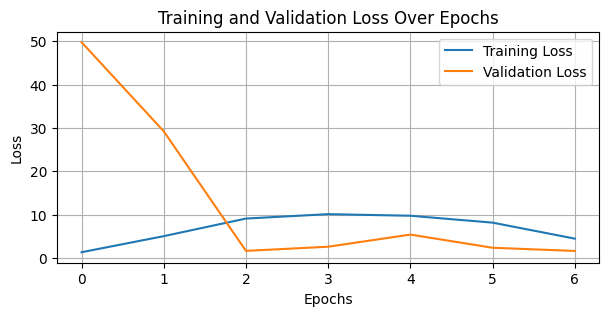

In [78]:
# Plot Training Loss and Validation Loss
plt.figure(figsize=(7, 3))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.grid(True)

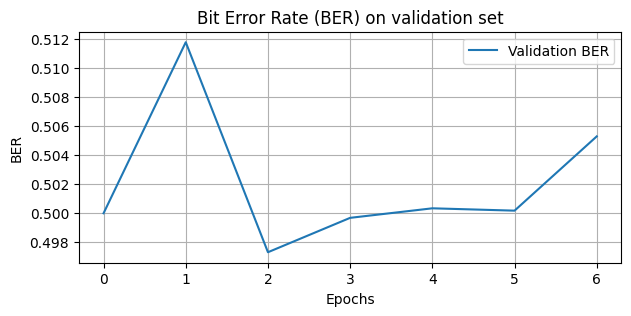

In [79]:
# Plot Validation BER
plt.figure(figsize=(7, 3))
plt.plot(val_BERs, label='Validation BER')
plt.xlabel('Epochs')
plt.ylabel('BER')
plt.legend()
plt.title('Bit Error Rate (BER) on validation set')
plt.grid(True)

In [97]:
class EnhancedSimpleModel7(nn.Module):

    def __init__(self, num_bits_per_symbol, H=64, W=512):
        super(EnhancedSimpleModel7, self).__init__()
        scale = 8
        self.linear1 = nn.Linear(in_features=2, out_features=scale * num_bits_per_symbol)
        self.linear2 = nn.Linear(in_features=scale * num_bits_per_symbol, out_features=scale * num_bits_per_symbol * 2)
        self.linear3 = nn.Linear(in_features=scale * num_bits_per_symbol * 2, out_features=scale * num_bits_per_symbol * 2)
        self.linear4 = nn.Linear(in_features=scale * num_bits_per_symbol * 2, out_features=scale * num_bits_per_symbol * 2)
        self.linear5 = nn.Linear(in_features=scale * num_bits_per_symbol * 2, out_features=scale * num_bits_per_symbol)
        self.linear6 = nn.Linear(in_features=scale * num_bits_per_symbol, out_features=num_bits_per_symbol)
        self.activation = nn.LeakyReLU()


    def forward(self, inputs):
        y = inputs
        z = torch.stack([y.real, y.imag], dim=0)
        z = z.permute(1, 2, 3, 0)
        z = self.linear1(z)
        z = self.activation(z)
        z = self.linear2(z)
        z = self.activation(z)
        z = self.linear3(z)
        z = self.activation(z)
        z = self.linear4(z)
        z = self.activation(z)
        z = self.linear5(z)
        z = self.activation(z)
        z = self.linear6(z)
        z = nn.Sigmoid()(z)
        z = z.flatten(-2, -1)
        return z

In [98]:
model = EnhancedSimpleModel7(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength)
output = model(onebatch['samples']) #[32, 64, 512] =>[32, 64, 1024]
# Setup loss and optimizer pip install ipywidgets
loss_fn = nn.BCELoss() #nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)


In [99]:
train_losses = []
val_losses = []
val_BERs = []

In [100]:
model=model.to(device)

In [101]:
from tqdm.auto import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Initialize the ReduceLROnPlateau scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, threshold=0.001)

start_epoch = 0
num_epochs = 20
for epoch in range(start_epoch, num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0.0

    for data_batch in tqdm(train_loader):
        batch = {k: v.to(device) for k, v in data_batch.items()}
        samples = batch['samples']
        labels = batch['labels']
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(samples)  # forward pass
        loss = loss_fn(outputs, labels)
        loss.backward()  # backward pass
        optimizer.step()  # update the weights
        total_loss += loss.item()  # accumulate the loss

    # Print average loss for the epoch
    average_loss = total_loss / len(train_loader)

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    total_val_loss = 0.0
    BER_batch = []
    with torch.no_grad():
        for data_batch in tqdm(val_loader):
            batch = {k: v.to(device) for k, v in data_batch.items()}
            samples = batch['samples']
            labels = batch['labels']
            val_outputs = model(samples)
            val_loss = loss_fn(val_outputs, labels)
            total_val_loss += val_loss.item()

            binary_predictions = torch.round(val_outputs)
            error_count = torch.sum(binary_predictions != labels).float()
            error_rate = error_count / len(labels.flatten())
            BER_batch.append(error_rate.item())

    
    average_val_loss = total_val_loss / len(val_loader)
    BER_batch_mean = np.mean(BER_batch)
    scheduler.step(average_val_loss)
    train_losses.append(average_loss)
    val_losses.append(val_loss.item())
    BER_batch_mean=np.mean(BER_batch)
    val_BERs.append(BER_batch_mean)#(BER.item())

    # Logging
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}, Val Loss: {average_val_loss:.4f}, Val BER: {BER_batch_mean:.4f}")


100%|████████████████████████████████████████| 640/640 [00:04<00:00, 134.37it/s]


Epoch [1/20], Loss: 0.6296, Val Loss: 0.5262, Val BER: 0.2582


100%|████████████████████████████████████████| 640/640 [00:04<00:00, 139.32it/s]


Epoch [2/20], Loss: 0.4554, Val Loss: 0.4354, Val BER: 0.1956


100%|████████████████████████████████████████| 640/640 [00:04<00:00, 137.94it/s]


Epoch [3/20], Loss: 0.4219, Val Loss: 0.4287, Val BER: 0.1933


100%|████████████████████████████████████████| 640/640 [00:04<00:00, 135.67it/s]


Epoch [4/20], Loss: 0.4177, Val Loss: 0.4272, Val BER: 0.1948


100%|████████████████████████████████████████| 640/640 [00:05<00:00, 121.17it/s]


Epoch [5/20], Loss: 0.4168, Val Loss: 0.4301, Val BER: 0.1927


100%|████████████████████████████████████████| 640/640 [00:05<00:00, 117.02it/s]


Epoch [6/20], Loss: 0.4137, Val Loss: 0.4291, Val BER: 0.1939


100%|█████████████████████████████████████████| 640/640 [00:06<00:00, 98.94it/s]


Epoch [7/20], Loss: 0.4129, Val Loss: 0.4242, Val BER: 0.1942


100%|████████████████████████████████████████| 640/640 [00:05<00:00, 114.14it/s]


Epoch [8/20], Loss: 0.4142, Val Loss: 0.4258, Val BER: 0.1931


100%|████████████████████████████████████████| 640/640 [00:05<00:00, 125.08it/s]


Epoch [9/20], Loss: 0.4112, Val Loss: 0.4209, Val BER: 0.1919


100%|████████████████████████████████████████| 640/640 [00:04<00:00, 129.38it/s]


Epoch [10/20], Loss: 0.4163, Val Loss: 0.4257, Val BER: 0.1928


100%|████████████████████████████████████████| 640/640 [00:05<00:00, 121.67it/s]


Epoch [11/20], Loss: 0.4147, Val Loss: 0.4268, Val BER: 0.1927


100%|████████████████████████████████████████| 640/640 [00:05<00:00, 124.27it/s]


Epoch [12/20], Loss: 0.4160, Val Loss: 0.4348, Val BER: 0.1920


100%|████████████████████████████████████████| 640/640 [00:04<00:00, 129.84it/s]


Epoch [13/20], Loss: 0.4141, Val Loss: 0.4263, Val BER: 0.1934


100%|████████████████████████████████████████| 640/640 [00:05<00:00, 127.05it/s]


Epoch [14/20], Loss: 0.4071, Val Loss: 0.4189, Val BER: 0.1909


100%|████████████████████████████████████████| 640/640 [00:04<00:00, 129.25it/s]


Epoch [15/20], Loss: 0.4060, Val Loss: 0.4182, Val BER: 0.1909


100%|████████████████████████████████████████| 640/640 [00:05<00:00, 125.84it/s]


Epoch [16/20], Loss: 0.4057, Val Loss: 0.4185, Val BER: 0.1908


100%|████████████████████████████████████████| 640/640 [00:05<00:00, 127.02it/s]


Epoch [17/20], Loss: 0.4065, Val Loss: 0.4176, Val BER: 0.1907


100%|████████████████████████████████████████| 640/640 [00:04<00:00, 135.31it/s]


Epoch [18/20], Loss: 0.4057, Val Loss: 0.4184, Val BER: 0.1907


100%|████████████████████████████████████████| 640/640 [00:04<00:00, 134.09it/s]


Epoch [19/20], Loss: 0.4058, Val Loss: 0.4177, Val BER: 0.1908


100%|████████████████████████████████████████| 640/640 [00:04<00:00, 132.81it/s]

Epoch [20/20], Loss: 0.4056, Val Loss: 0.4193, Val BER: 0.1908


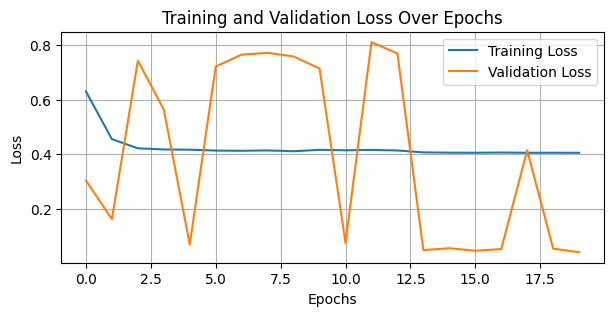

In [102]:
# Plot Training Loss and Validation Loss
plt.figure(figsize=(7, 3))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.grid(True)

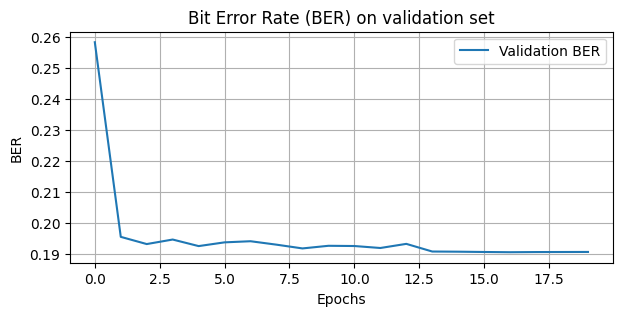

In [103]:
# Plot Validation BER
plt.figure(figsize=(7, 3))
plt.plot(val_BERs, label='Validation BER')
plt.xlabel('Epochs')
plt.ylabel('BER')
plt.legend()
plt.title('Bit Error Rate (BER) on validation set')
plt.grid(True)

In [128]:
class EnhancedSimpleModel8(nn.Module):

    def __init__(self, num_bits_per_symbol, H=64, W=512):
        super(EnhancedSimpleModel8, self).__init__()
        scale = 8
        self.linear1 = nn.Linear(in_features=2, out_features=scale * num_bits_per_symbol)
        self.linear2 = nn.Linear(in_features=scale * num_bits_per_symbol, out_features=scale * num_bits_per_symbol * 2)
        self.linear3 = nn.Linear(in_features=scale * num_bits_per_symbol * 2, out_features=scale * num_bits_per_symbol)
        self.linear4 = nn.Linear(in_features=scale * num_bits_per_symbol, out_features=num_bits_per_symbol)
        self.activation = nn.LeakyReLU()

    def forward(self, inputs):
        y = inputs
        z = torch.stack([y.real, y.imag], dim=0)
        z = z.permute(1, 2, 3, 0)
        z = self.linear1(z)
        z = self.activation(z)
        z = self.linear2(z)
        z = self.activation(z)
        z = self.linear3(z)
        z = self.activation(z)
        z = self.linear4(z)
        z = nn.Sigmoid()(z)
        z = z.flatten(-2, -1)
        return z

In [129]:
model = EnhancedSimpleModel8(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength)

In [130]:
# Setup loss and optimizer pip install ipywidgets
loss_fn = nn.BCELoss() #nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum = 0.9)

In [131]:
train_losses = []
val_losses = []
val_BERs = []

In [132]:
model=model.to(device)

In [133]:
from tqdm.auto import tqdm
# Training loop
start_epoch = 0
num_epochs = 20
for epoch in range(start_epoch, num_epochs):
    total_loss = 0.0
    model.train()  # Set the model to training mode

    for index, data_batch in enumerate(tqdm(train_loader)):
        batch = {k: v.to(device) for k, v in data_batch.items()}
        samples = batch['samples']
        labels = batch['labels']
        outputs = model(samples)  # forward pass
        loss = loss_fn(outputs, labels)
        loss.backward()  # backward pass
        optimizer.step()  # update the weights
        total_loss += loss.item()  # accumulate the loss
        optimizer.zero_grad()  # Zero the gradients

    # Print average loss for the epoch
    average_loss = total_loss / len(train_loader)

    # Validation
    model.eval()  # Set the model to evaluation mode
    BER_batch=[]
    with torch.no_grad():
        for index, data_batch in enumerate(tqdm(val_loader)):
            batch = {k: v.to(device) for k, v in data_batch.items()}
            samples = batch['samples']
            labels = batch['labels']
            val_outputs = model(samples)
            val_loss = loss_fn(val_outputs, labels)

            # Convert probabilities to binary predictions (0 or 1)
            binary_predictions = torch.round(val_outputs)

            # Calculate Bit Error Rate (BER)
            error_count = torch.sum(binary_predictions != labels).float()  # Count of unequal bits
            error_rate = error_count / len(labels.flatten())  # Error rate calculation
            BER_batch.append(error_rate.item())

    # Save performance details
    train_losses.append(average_loss)
    val_losses.append(val_loss.item())
    BER_batch_mean=np.mean(BER_batch)
    val_BERs.append(BER_batch_mean)#(BER.item())

    # Print or log validation loss after each epoch
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}, Val Loss: {val_loss:.4f}, Val BER: {BER_batch_mean:.4f}")


100%|████████████████████████████████████████| 640/640 [00:03<00:00, 191.82it/s]


Epoch [1/20], Loss: 0.6534, Val Loss: 0.5508, Val BER: 0.3046


100%|████████████████████████████████████████| 640/640 [00:03<00:00, 204.87it/s]


Epoch [2/20], Loss: 0.5732, Val Loss: 0.4413, Val BER: 0.2062


100%|████████████████████████████████████████| 640/640 [00:03<00:00, 202.38it/s]


Epoch [3/20], Loss: 0.5369, Val Loss: 0.5575, Val BER: 0.2027


100%|████████████████████████████████████████| 640/640 [00:03<00:00, 198.65it/s]


Epoch [4/20], Loss: 0.4939, Val Loss: 0.7969, Val BER: 0.1922


100%|████████████████████████████████████████| 640/640 [00:03<00:00, 195.00it/s]


Epoch [5/20], Loss: 0.4569, Val Loss: 0.7804, Val BER: 0.1916


100%|████████████████████████████████████████| 640/640 [00:03<00:00, 190.25it/s]


Epoch [6/20], Loss: 0.4389, Val Loss: 0.7645, Val BER: 0.1917


100%|████████████████████████████████████████| 640/640 [00:03<00:00, 189.98it/s]


Epoch [7/20], Loss: 0.4321, Val Loss: 0.2104, Val BER: 0.1914


100%|████████████████████████████████████████| 640/640 [00:03<00:00, 166.58it/s]


Epoch [8/20], Loss: 0.4286, Val Loss: 0.1283, Val BER: 0.1916


100%|████████████████████████████████████████| 640/640 [00:04<00:00, 148.24it/s]


Epoch [9/20], Loss: 0.4266, Val Loss: 0.6283, Val BER: 0.1916


100%|████████████████████████████████████████| 640/640 [00:04<00:00, 133.63it/s]


Epoch [10/20], Loss: 0.4248, Val Loss: 0.7726, Val BER: 0.1913


100%|████████████████████████████████████████| 640/640 [00:04<00:00, 136.86it/s]


Epoch [11/20], Loss: 0.4233, Val Loss: 0.1547, Val BER: 0.1917


100%|████████████████████████████████████████| 640/640 [00:03<00:00, 165.07it/s]


Epoch [12/20], Loss: 0.4220, Val Loss: 0.7836, Val BER: 0.1910


100%|████████████████████████████████████████| 640/640 [00:03<00:00, 163.23it/s]


Epoch [13/20], Loss: 0.4210, Val Loss: 0.1149, Val BER: 0.1910


100%|████████████████████████████████████████| 640/640 [00:03<00:00, 175.79it/s]


Epoch [14/20], Loss: 0.4201, Val Loss: 0.7463, Val BER: 0.1911


100%|████████████████████████████████████████| 640/640 [00:03<00:00, 182.00it/s]


Epoch [15/20], Loss: 0.4195, Val Loss: 0.1795, Val BER: 0.1907


100%|████████████████████████████████████████| 640/640 [00:03<00:00, 187.74it/s]


Epoch [16/20], Loss: 0.4190, Val Loss: 0.7754, Val BER: 0.1907


100%|████████████████████████████████████████| 640/640 [00:03<00:00, 185.20it/s]


Epoch [17/20], Loss: 0.4184, Val Loss: 0.1204, Val BER: 0.1913


100%|████████████████████████████████████████| 640/640 [00:03<00:00, 185.13it/s]


Epoch [18/20], Loss: 0.4180, Val Loss: 0.7194, Val BER: 0.1911


100%|████████████████████████████████████████| 640/640 [00:03<00:00, 184.63it/s]


Epoch [19/20], Loss: 0.4178, Val Loss: 0.5115, Val BER: 0.1909


100%|████████████████████████████████████████| 640/640 [00:03<00:00, 179.12it/s]

Epoch [20/20], Loss: 0.4172, Val Loss: 0.7021, Val BER: 0.1906


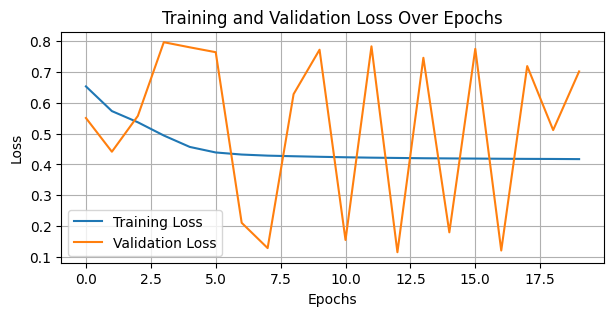

In [134]:
# Plot Training Loss and Validation Loss
plt.figure(figsize=(7, 3))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.grid(True)

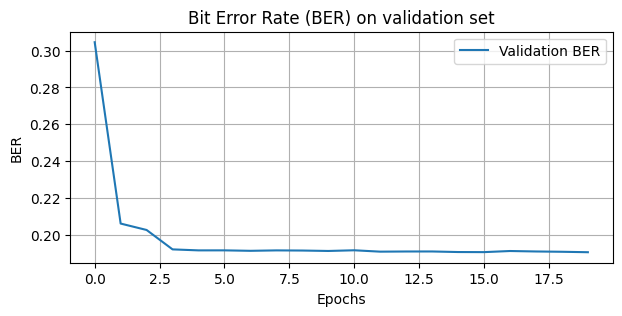

In [135]:
# Plot Validation BER
plt.figure(figsize=(7, 3))
plt.plot(val_BERs, label='Validation BER')
plt.xlabel('Epochs')
plt.ylabel('BER')
plt.legend()
plt.title('Bit Error Rate (BER) on validation set')
plt.grid(True)

In [109]:
def load_model(model_path, num_bits_per_symbol):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = EnhancedSimpleModel7(num_bits_per_symbol=num_bits_per_symbol).to(device)
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()  # Set the model to evaluation mode
    return model

In [110]:
def evaluate_model_performance(model, num_bits_per_symbol, snr_levels, frame_size=64, blocklength=1024, batch_size=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    snr_to_ber = {}
    for snr in snr_levels:
        dataset = ComplexDataset(num_bits_per_symbol=num_bits_per_symbol, Frame_SIZE=frame_size, Blocklength=blocklength, DB_MIN=snr, DB_MAX=snr, totaldbs=batch_size)
        dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False)

        total_errors, total_bits = 0, 0
        with torch.no_grad():
            for data_batch in dataloader:
                samples, labels = data_batch['samples'].to(device), data_batch['labels'].to(device)
                outputs = model(samples)
                predicted_bits = torch.round(outputs)
                total_errors += (predicted_bits != labels).sum().item()
                total_bits += labels.numel()

        ber = total_errors / total_bits
        snr_to_ber[snr] = ber

    return snr_to_ber

In [111]:
# Save the final trained model
checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
}
modelsave_path = os.path.join(trainoutput, 'Enhanced_Simple_Model7.pth')
torch.save(checkpoint, modelsave_path)

In [120]:
model_path = 'Enhanced_Simple_Model7.pth'
num_bits_per_symbol = 4  # Example: 4 for 16-QAM
snr_levels = np.linspace(-40, 40, 10)  # Example: from -10 dB to 20 dB, with 7 points

# Load the pre-trained model
model = load_model(model_path, num_bits_per_symbol)

# Evaluate the model's performance
snr_to_ber = evaluate_model_performance(model, num_bits_per_symbol, snr_levels)

# Print or plot the results
for snr, ber in snr_to_ber.items():
    print(f"SNR: {snr} dB, BER: {ber}")

(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
(16,)
SNR: -40.0 dB, BER: 0.4968109130859375
SNR: -31.11111111111111 dB, BER: 0.4883270263671875
SNR: -22.22222222222222 dB, BER: 0.470947265625
SNR: -13.333333333333332 dB, BER: 0.4149932861328125
SNR: -4.444444444444443 dB, BER: 0.246551513671875
SNR: 4.444444444444443 dB, BER: 0.0519256591796875
SNR: 13.333333333333336 dB, BER: 1.52587890625e-05
SNR: 22.22222222222223 dB, BER: 0.0
SNR: 31.111111111111114 dB, BER: 0.0
SNR: 40.0 dB, BER: 0.0


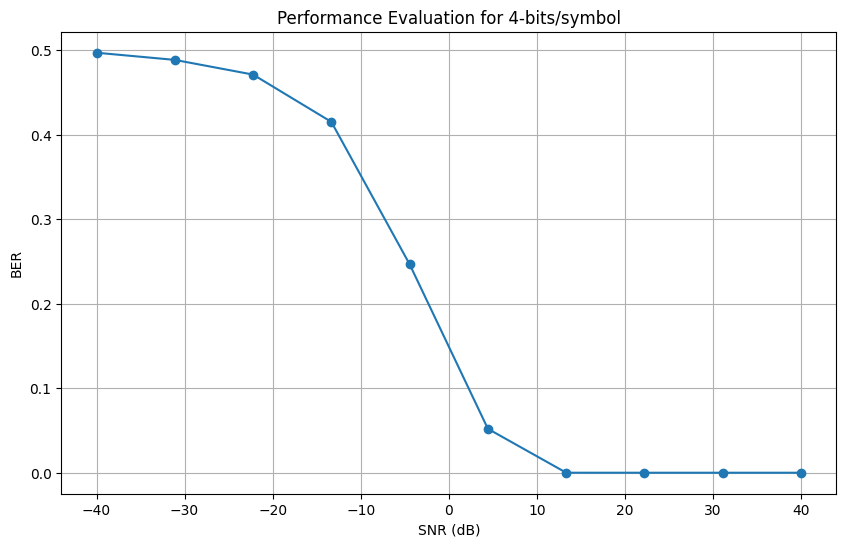

In [121]:
plt.figure(figsize=(10, 6))
plt.plot(snr_levels, list(snr_to_ber.values()), marker='o', linestyle='-')
plt.xlabel('SNR (dB)')
plt.ylabel('BER')
#plt.yscale('log')
plt.title(f'Performance Evaluation for {num_bits_per_symbol}-bits/symbol')
plt.grid(True)
plt.show()